# Instance Segmentation of WorldView Imagery Using Mask RCNN

The following notebook performs object detection and segmentation of satellite imagery, particularly very high-resolution World View data. The notebook outlines every step of the pipeline which is controlled by general configuration variables in the variables section and some configuration files.

The general idea of this notebook comes from use cases where a set of continuous labels is not possible due to the charasteristic of the object. For example, a feature that can only be seen once in a large extent of area. The Mask RCNN network job then is to identify a region of interest (ROI) as a bounding box, and then segment inside the ROI the feature of importance.

In this particular example, we will look at cloud segmentation as a toy dataset, but this notebook has been used for preliminary work on slump and mangrove detection from WorldView imagery. In this example we are using as pretrained ResNet backbone trained on ImageNet imagery.

Author: Jordan A. Caraballo-Vega - NASA GSFC, <jordan.a.caraballo-vega@nasa.gov>  
Release Date: 07/23/2021  
Version: 2021.10

## 1. Usage and installation requirements

### 1.1 Creating a conda environment (One time only)

In order to run this notebook you will need a conda environment with all dependencies installed. ADAPT provides a built-in environment from the JupyterHub interface that is only missing a couple of packages that can be installed on the fly. In order to get started quickly, follow the next steps:

1. Login to adaptlogin.nccs.nasa.gov
2. Load the Anaconda module

```bash
module load anaconda
```

3. Clone the existing environment

```bash
conda create --name slump-detection-11.1 --clone /att/nobackup/jacaraba/.conda/envs/slump-detection-11.1
```

Now you are ready to move on to JupyterHub.


### 1.2 Login to ADAPT JupyterHub

To leverage NCCS ADAPT resources, you will need to login to ADAPT JupyterHub. The steps are outlined below.

1. Login to the NCCS JupyterHub https://www-proxy-dev.nccs.nasa.gov/jupyterhub-prism/.
2. Open this notebook via the file/upload method.
3. Select kernel, in this case "slump-detection-11.1".
4. Start working on your notebook.

## 2. Define global variables for the CNN pipeline

Here we define some global variables to control the behaviour of the notebook. Particularly we look at the configuration file and pipeline steps to execute in the call of this notebook. This is useful when running the entire notebook trying to execute a single section of it like training, preprocessing, visualizing or predicting.

In [1]:
CONFIG = 'config/cloud_mask_rcnn_R_50_FPN_3x.yaml'
PREPROCESS = True
VIS = True
TRAIN = True
PREDICT = True

### 2.1 Import Python Libraries

In this section we include all Python libraries required to execute the code below. There are no external code dependencies besides the packages installed under section 1.1.

In [2]:
import os
import glob
import time
import torch
import numpy as np

In [3]:
import cv2
import xarray as xr
import rioxarray as rxr
from skimage.util import img_as_ubyte
from skimage import exposure
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from core.utils import arg_parser, get_bands, gen_data_png, gen_coco_dataset
from core.utils import predict_batch, arr_to_tif

In [5]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(22)

### 2.2 Read configuration file

In this section we read the configuration file and initialize the configuration object used by the framework.

In [6]:
cfg = get_cfg()  # get default configurations in place
cfg.set_new_allowed(True)  # allow for new configuration objects
cfg.INPUT.MIN_SIZE_TRAIN = 256  # small hack to allow merging new fields
cfg.merge_from_file(CONFIG)  # merge from file

## 3. Preprocessing

In this section we extract dataset tiles from label and imagery rasters. The general idea here is to extract the information we need straight from the binary mask given. We extract the mask location, the bounding box that surrounds that mask, and the image information to create the COCO dataset JSON file.

### 3.1 Generate Dataset

Go through each one of the training data files, and extract tiles for training, validation, and testing. We then store our imagery in png format for the model to be able to read it during training.

In [7]:
if PREPROCESS:
    
    # Process each image individually
    for image, label in zip(cfg.DATASETS.IMAGES, cfg.DATASETS.LABELS):

        # read input data
        image_data = rxr.open_rasterio(image).transpose("y", "x", "band")
        label_data = rxr.open_rasterio(label).squeeze().values.astype(np.uint8)
        print("Image and label shapes: ", image_data.shape, label_data.shape)

        # drop bands we are not interested in given the ones we actually want
        image_data = get_bands(
            image_data, cfg.INPUT.INPUT_BANDS, cfg.INPUT.OUTPUT_BANDS
        ).values.astype(np.int16)
        print("Image after get_bands: ", image_data.shape, label_data.shape)

        # EVHR outputs values outside of allowed range [0,10000]
        image_data = np.clip(image_data, 0, 10000)

        # lower resolution here
        image_data = exposure.rescale_intensity(img_as_ubyte(image_data))

        # transforming 1 to 255 for now to visualize locally
        label_data[label_data == 1] = 255

        # extract tiles from the imagery and generate masks
        for set in ['TRAIN', 'TEST', 'VAL']:
            gen_data_png(image, image_data, label_data, cfg, set=set)
            gen_coco_dataset(cfg, set=set, img_reg='*_img_*.png', label_reg='*_lbl_*.png')

Image and label shapes:  (5000, 5000, 6) (5000, 5000)
Image after get_bands:  (5000, 5000, 3) (5000, 5000)
Saving file under: /lscratch/jacaraba/cloud-detection-data/TRAIN


  0%|          | 0/200 [00:00<?, ?it/s]

Number of train and mask images: 400 0 without annotations.
Saving file under: /lscratch/jacaraba/cloud-detection-data/TEST


  0%|          | 0/40 [00:00<?, ?it/s]

Number of train and mask images: 80 0 without annotations.
Saving file under: /lscratch/jacaraba/cloud-detection-data/VAL


  0%|          | 0/40 [00:00<?, ?it/s]

Number of train and mask images: 80 0 without annotations.
Image and label shapes:  (5000, 5000, 6) (5000, 5000)
Image after get_bands:  (5000, 5000, 3) (5000, 5000)
Saving file under: /lscratch/jacaraba/cloud-detection-data/TRAIN


  0%|          | 0/200 [00:00<?, ?it/s]

Number of train and mask images: 400 0 without annotations.
Saving file under: /lscratch/jacaraba/cloud-detection-data/TEST


  0%|          | 0/40 [00:00<?, ?it/s]

Number of train and mask images: 80 0 without annotations.
Saving file under: /lscratch/jacaraba/cloud-detection-data/VAL


  0%|          | 0/40 [00:00<?, ?it/s]

Number of train and mask images: 80 0 without annotations.


### 3.2 Visualize some training tiles

The following imagery shows some of the training tiles and masks that have been fed to the JSON dataset. Bounding boxes where extracted from the masks shown below.

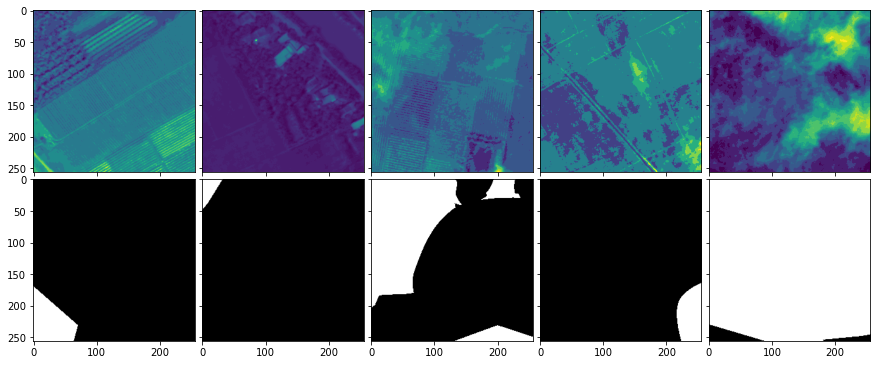

In [8]:
if VIS:

    vis_dir = os.path.join(cfg.DATASETS.OUTPUT_DIRECTORY, 'TRAIN')
    images = sorted(glob.glob(os.path.join(vis_dir, '*_img_*.png')))[:5]
    labels = sorted(glob.glob(os.path.join(vis_dir, '*_lbl_*.png')))[:5]
    
    for index in range(len(images)):
        images[index] = cv2.imread(images[index])[:, :, 2]
        labels[index] = cv2.imread(labels[index])

    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im_id in zip(grid, images + labels):
        # Iterating over the grid returns the Axes.
        ax.imshow(im_id, cmap='viridis')

    plt.show()

## 4. Train

Then we can proceed to training our model. We will leverage the TRAIN and VAL datasets to train and monitor the performance of the model.

In [9]:
if TRAIN:
    
    # Path and directory configurations
    input_dir = cfg.DATASETS.OUTPUT_DIRECTORY
    cfg.OUTPUT_DIR = cfg.MODEL.OUTPUT_DIRECTORY
    dataset_name = cfg.DATASETS.COCO_METADATA.DESCRIPTION

    # Registor COCO datasets for train, val, and test
    for curType in ['TRAIN', 'VAL', 'TEST']:
        curJson = os.path.join(
            input_dir, dataset_name + '_' + curType + '.json'
        )
        curDir = os.path.join(input_dir, curType)
        register_coco_instances(
            f'{dataset_name}_{curType}', {}, curJson, curDir
        )

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    finalModelPath = os.path.join(cfg.OUTPUT_DIR, cfg.MODEL.MODEL_NAME)

    if os.path.isfile(finalModelPath) and cfg.MODEL.DELETE_MODEL:
        os.remove(finalModelPath)
        print("WARNING: deleted existing model, re-training")

    if not os.path.isfile(finalModelPath):  # no re-run training unless cleared
        trainer = DefaultTrainer(cfg)
        trainer.resume_or_load(resume=False)
        trainer.train()

[03/02 11:35:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[03/02 11:35:06 d2.engine.train_loop]: Starting training from iteration 0
[03/02 11:35:17 d2.utils.events]:  eta: 0:01:37  iter: 19  total_loss: 2.137  loss_cls: 0.3162  loss_box_reg: 0.3989  loss_mask: 0.6917  loss_rpn_cls: 0.7036  loss_rpn_loc: 0.008996  time: 0.3515  data_time: 0.0940  lr: 0.00016068  max_mem: 2498M
[03/02 11:35:24 d2.utils.events]:  eta: 0:01:29  iter: 39  total_loss: 1.782  loss_cls: 0.2213  loss_box_reg: 0.3889  loss_mask: 0.64  loss_rpn_cls: 0.5138  loss_rpn_loc: 0.008766  time: 0.3461  data_time: 0.0642  lr: 0.00032718  max_mem: 2589M
[03/02 11:35:31 d2.utils.events]:  eta: 0:01:22  iter: 59  total_loss: 1.33  loss_cls: 0.1709  loss_box_reg: 0.4045  loss_mask: 0.5594  loss_rpn_cls: 0.19  loss_rpn_loc: 0.01013  time: 0.3471  data_time: 0.0668  lr: 0.00049367  max_mem: 2589M
[03/02 11:35:38 d2.utils.events]:  eta: 0:01:15  iter: 79  total_loss: 1.042  loss_cls: 0.128  loss_box_reg: 0.3846  loss_mask: 0.4305  loss_rpn_cls: 0.08992  loss_rpn_loc: 0.01257  time: 0.3

## 5. Predict

Classify the images fed in raster format, extract a single file binary mask as the final product.

In [10]:
if PREDICT:

    # Path and directory configurations
    cfg.OUTPUT_DIR = cfg.MODEL.OUTPUT_DIRECTORY
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    # setting up model information
    model_weights = os.path.join(cfg.OUTPUT_DIR, cfg.MODEL.MODEL_NAME)
    cfg.MODEL.WEIGHTS = model_weights

    # build model and model metadata
    model = build_model(cfg)  # build architecture and maps
    model_dict = torch.load(model_weights, map_location=torch.device('cpu'))
    model.load_state_dict(model_dict['model'])  # load metadata

    model.train(False)  # we are predicting, weights are already updated

    # Get list of files to predict
    if isinstance(cfg.PREDICTOR.PRED_FILENAMES, str):
        cfg.PREDICTOR.PRED_FILENAMES = glob.glob(cfg.PREDICTOR.PRED_FILENAMES)
    print(f'Number of files to predict: {len(cfg.PREDICTOR.PRED_FILENAMES)}')

    # Tterate over files and predict them
    for fname in cfg.PREDICTOR.PRED_FILENAMES:

        # measure execution time
        start_time = time.perf_counter()

        # path + name to store prediction into
        save_image = \
            cfg.OUTPUT_DIR + '/' + fname[:-4].split('/')[-1] + '_pred.tif'

        print(f'Starting to predict {fname}')

        # Extracting and resizing test and validation data
        x_data = xr.open_rasterio(
            fname, chunks=dict(cfg.DATALOADER.DASK_SIZE)
        ).astype(np.int32)
        x_data = get_bands(
            x_data, cfg.INPUT.INPUT_BANDS, cfg.INPUT.OUTPUT_BANDS
        )

        # Getting predicted labels
        prediction = predict_batch(x_data=x_data, model=model, config=cfg)
        prediction[prediction > 1] = 1
        prediction = prediction.astype(np.int8)  # type to int8

        # Generating visualization from prediction
        arr_to_tif(raster_f=fname, segments=prediction, out_tif=save_image)
        print(f'Saved image {save_image}.')
        del prediction

        print(f'Time: {(time.perf_counter() - start_time)}')

Number of files to predict: 1
Starting to predict /adapt/nobackup/projects/ilab/projects/Vietnam/Jordan/vhr-cloudmask-data/vietnam/demo/inference/Keelin04_20120531_data.tif
wsize: 3200x3200. Prediction shape: (5000, 5000)


  0%|          | 0/2 [00:00<?, ?it/s]

Saved image /lscratch/jacaraba/cloud-detection-data/Keelin04_20120531_data_pred.tif.
Time: 7.429967259988189


## 5.1 Visualize predictions on the test dataset

Lets visualize some of the predictions in the test dataset. 

[03/02 11:37:03 d2.data.datasets.coco]: Loaded 80 images in COCO format from /lscratch/jacaraba/cloud-detection-data/cloud-detection_trialrun_TEST.json


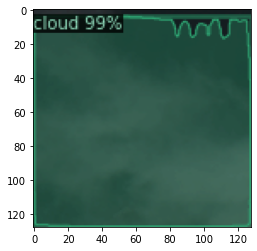

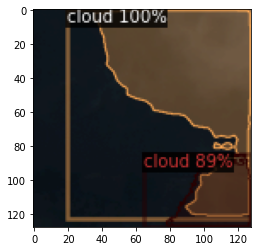

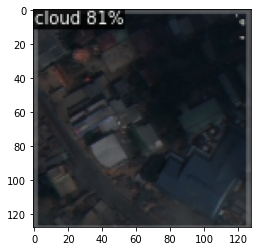

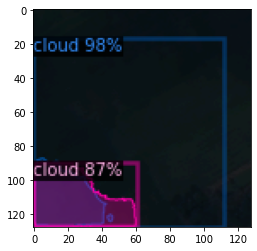

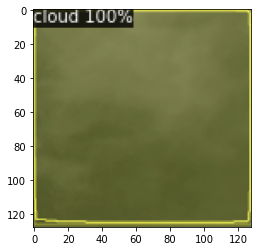

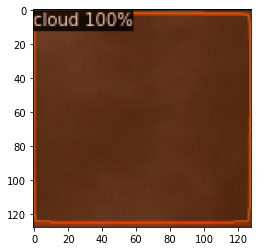

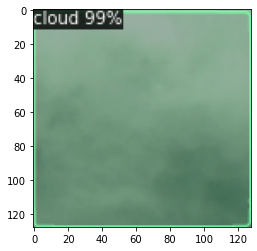

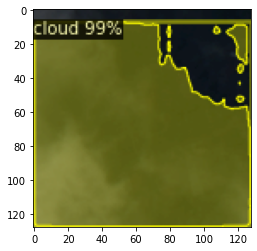

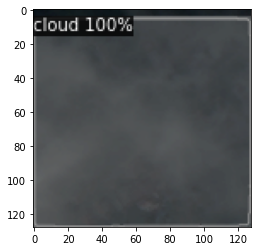

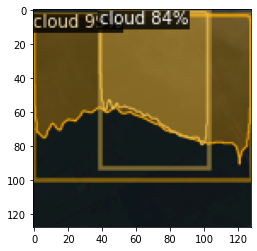

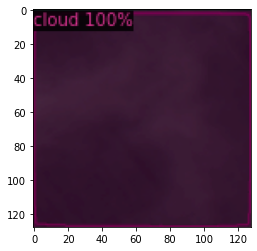

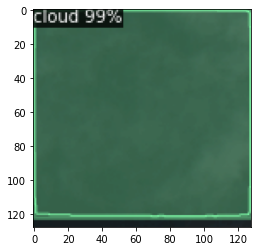

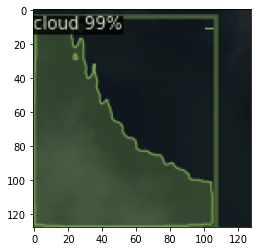

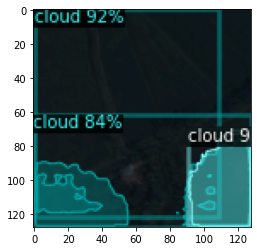

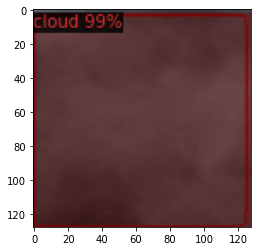

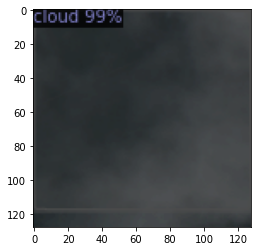

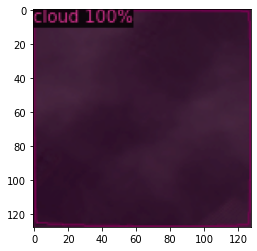

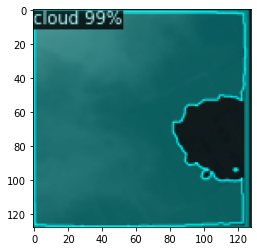

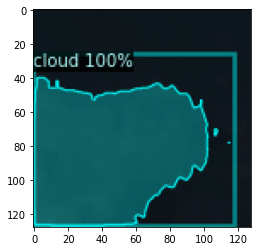

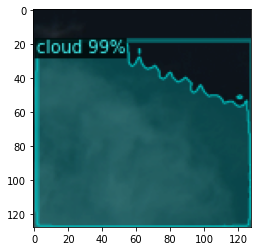

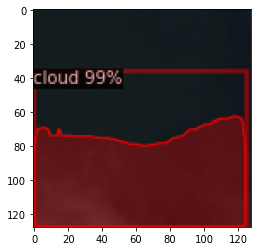

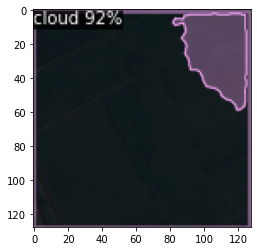

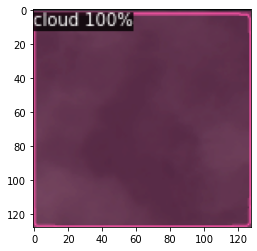

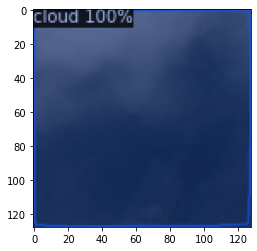

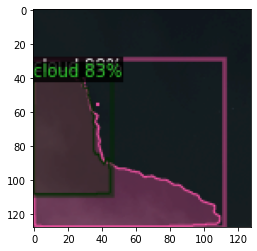

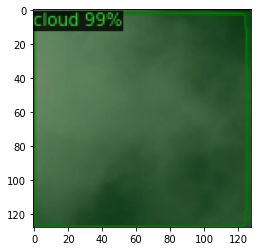

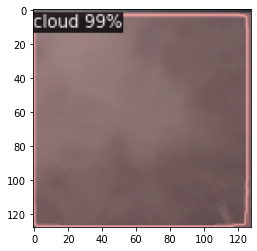

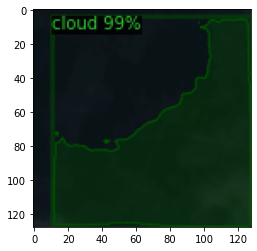

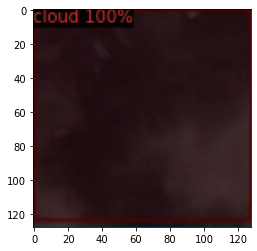

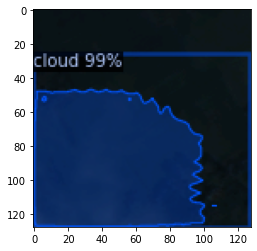

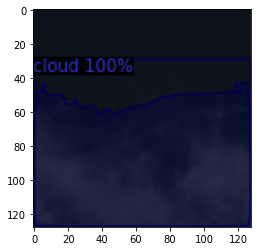

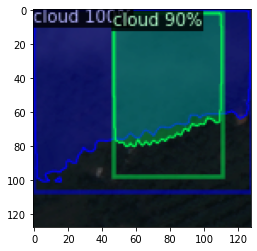

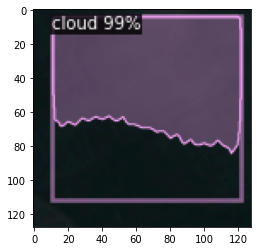

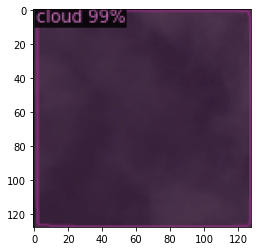

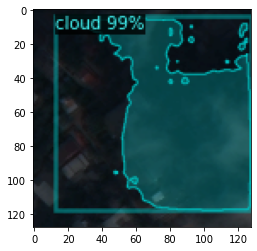

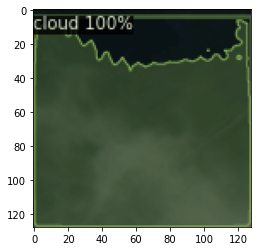

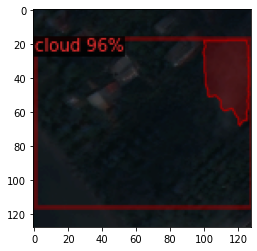

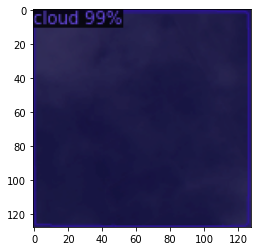

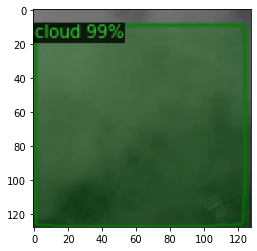

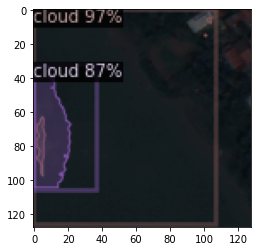

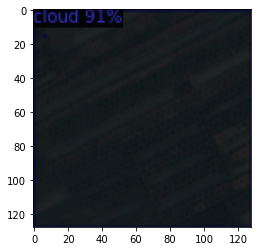

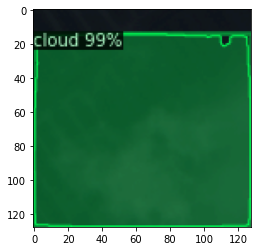

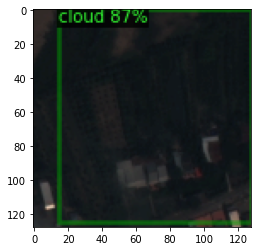

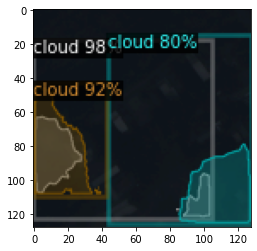

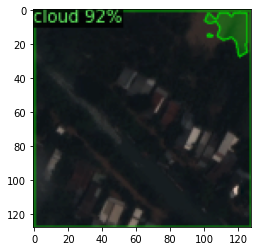

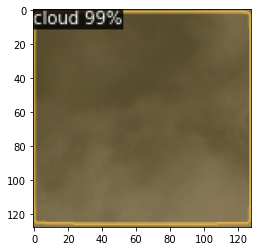

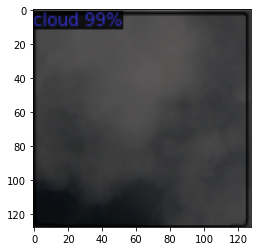

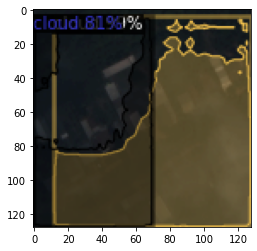

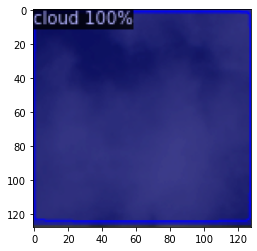

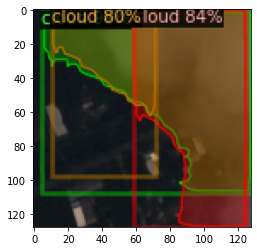

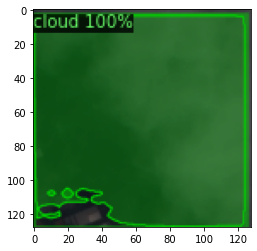

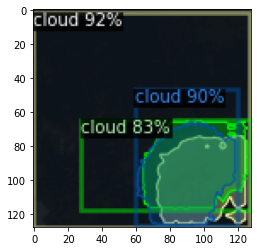

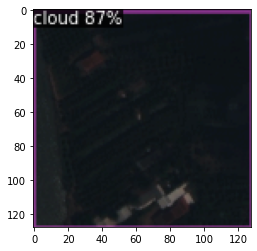

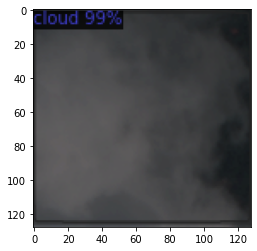

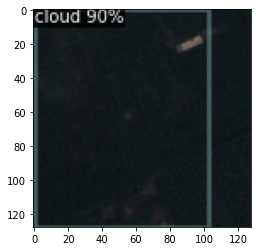

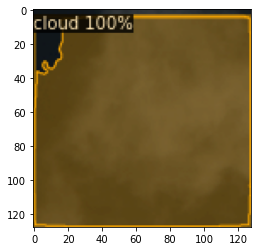

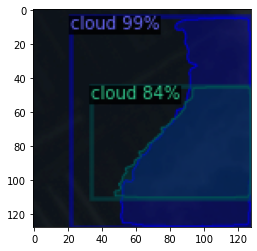

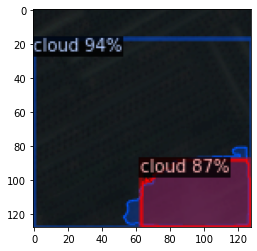

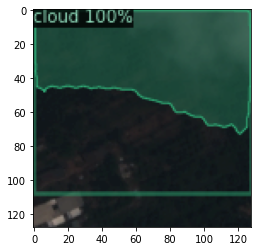

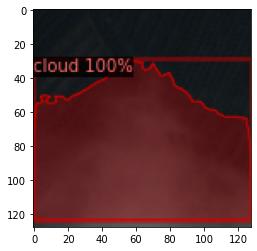

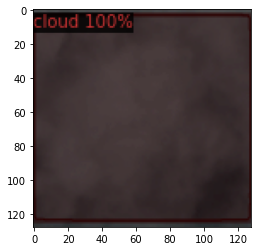

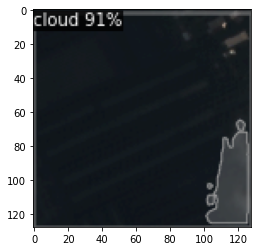

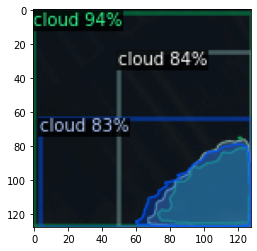

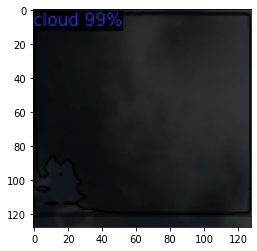

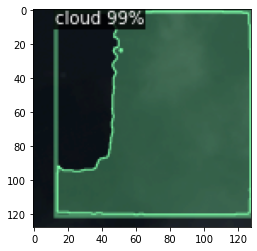

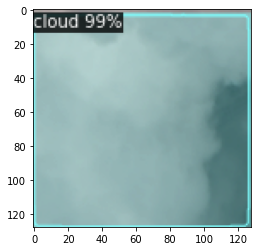

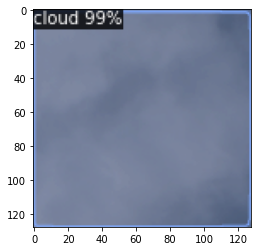

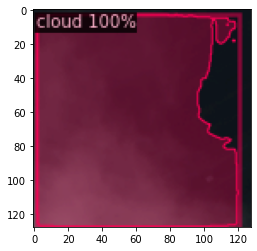

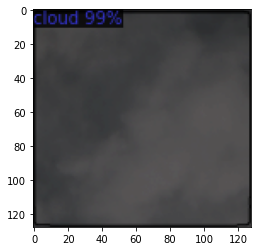

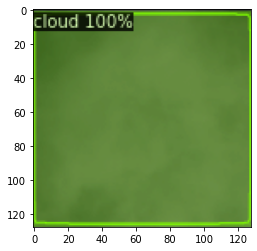

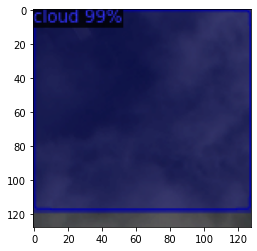

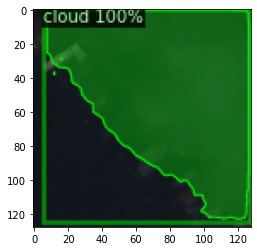

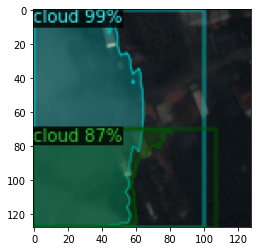

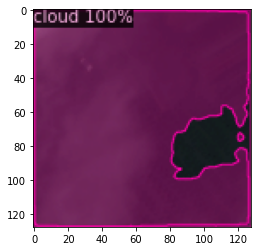

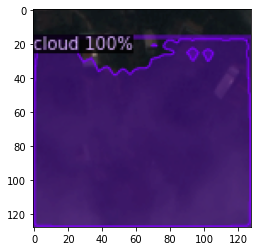

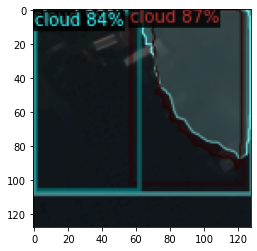

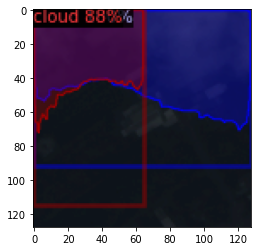

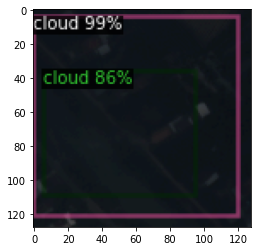

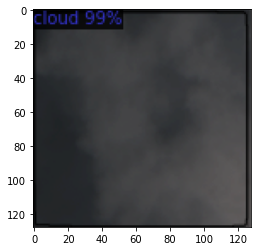

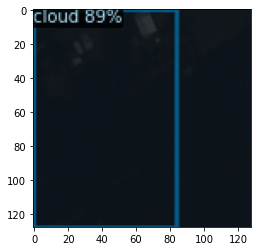

In [11]:
if PREDICT:

    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8

    dataset_name = cfg.DATASETS.COCO_METADATA.DESCRIPTION
    metadata = MetadataCatalog.get(dataset_name + '_TEST')
    dataset_dicts = DatasetCatalog.get(dataset_name + '_TEST')

    predictor = DefaultPredictor(cfg)
    for d in dataset_dicts:

        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=metadata,
                       scale=0.5,
                       instance_mode=ColorMode.IMAGE_BW
                       )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
        plt.imshow(img)
        plt.show()